# Numerical solution to the 1-dimensional Time Independent Schroedinger Equation
Based on the paper "Matrix Numerov method for solving Schroedinger's equation" by Mohandas Pillai, Joshua Goglio, and Thad G. Walker, _American Journal of Physics_ **80** (11), 1017 (2012).  [doi:10.1119/1.4748813](http://dx.doi.org/10.1119/1.4748813)

## Variational method
Using the Numerov approximation for the kinetic energy operator to calculate the expectation value of energy of a trial wavefunction.  From here, the energy may be minimized to find a variational solution.  Plot the ground state of this solution and the "true" solution, and compare their energies.


In [1]:
# import some needed libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integrate
%matplotlib inline

In [2]:
#import timeit # for timing the execution

In [3]:
autoscale = False # set this equal to true to use Pillai's recommended step sizes

This example is the finite square well.

Using units such that &hbar;, *m*, and *a* are one.

In [4]:
# values of constants
hbar = 1.0
mass = 1.0 # changing the mass will also change the energy scale
a = 1.0 # half width of the well (called a in the homework)
V0 = 18.0*np.sqrt(hbar/mass)/a**2

## Exact solution
Following McIntyre section 5.5, the exact energy must be found by solving a transcendental equation. We first define the dimensionless parameter

$$
z_0 = \sqrt{\frac{2mV_0a^2}{\hbar^2}}.
$$

Then, we solve the equations
$$
z \tan z = \sqrt{z_0^2 -z^2}\qquad\text{and}\qquad -z \cot z = \sqrt{z_0^2 -z^2},
$$
for all of the possible values of $z$.

For this problem, we only need the ground state, which will be given by the lowest $z$ value of the tangent equation.

In [5]:
z0 = np.sqrt(2*mass*V0)*a/hbar
print(z0)

6.0


In [6]:
#solve for z.  We know that the first solution must be in the range [0,π/2] by comparing to the "graphical method" of McIntyre.
z_solution = opt.root_scalar(lambda z: z*np.tan(z)-np.sqrt(z0**2-z**2), bracket=(0,np.pi/2))

z=z_solution.root
print(z)

1.344751045375789


Now that we know $z$, we can calculate energy and the exact wavefunction.

$$
z = \sqrt{\frac{2mEa^2}{\hbar^2}} \qquad \rightarrow \qquad E=\frac{\hbar^2}{2ma^2}\,z^2.
$$

In [7]:
E_exact = (z*hbar/a)**2/2/mass
print(E_exact)

0.9041776870196385


We need four parameters for the wavefunction:
$$
k = \frac{z}{a},\qquad q=\frac{\sqrt{z_0^2-z^2}}{a}. %k^2+q^2 = (z_0/a)^2
$$
Putting off normalization:
$$ D = 1,\qquad A=e^{qa}\cos(ka) =e^{\sqrt{z_0^2-z^2}} \cos z $$

In [8]:
k_exact = z/a
q_exact = np.sqrt(z0**2-z**2)/a
D_exact = 1.
A_exact = np.exp(np.sqrt(z0**2-z**2))*np.cos(z)
print(f"k={k_exact:.5f}, q={q_exact:.5f}, D={D_exact:.5f}, A={A_exact:.3f}")

k=1.34475, q=5.84736, D=1.00000, A=77.619


In [9]:
def psi_exact(x):
    # This is a long way to write the function, but it is clearer than the standard ways
    # normalized (integrated by hand)
    norm = 1/np.sqrt(a*(1+np.sin(2*z)/(2*z)+np.cos(z)**2/np.sqrt(z0**2-z**2)))
    # The booleans are zero except when true
    return norm* (((x<-1) * (A_exact*np.exp(q_exact*x))+
           ((x>=-1) * (x<=1)) * (D_exact*np.cos(k_exact*x))+
           (x>1) * (A_exact*np.exp(-q_exact*x))))
    

In [10]:
#check normalization.  This should be True.
np.isclose(integrate.quad(lambda x: np.abs(psi_exact(x))**2, -10,10)[0],1)

True

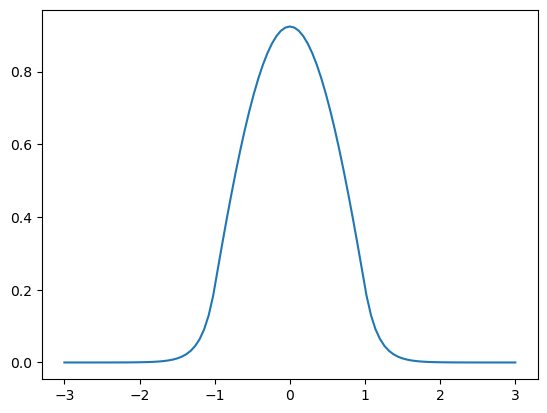

In [11]:
plt.plot(np.linspace(-3,3,101),psi_exact(np.linspace(-3,3,101)))

## Numerov method
The second solution is a discrete position basis matrix approximation using Numerov's approximation for the kinetic energy.  (See paper cited above.)  After calculating the approximate Hamiltonian as a matrix, the approximate eigenstates and energies are found by diagonalizing the Hamiltonian.

We'll also reuse the Hamiltonian from the Numerov method to calculate our variational energies in the next section.

In [12]:
# bounds (These are overwritten if autoscale=True)
xmin = -5.*a # lower bound of position
xmax = 5*a # upper bound of position
n = 200 # number of steps (may be overwritten if autoscale == True)
dx = (xmax-xmin)/(n-1)

In [13]:
# the function V is the potential energy function
def V(x):
    # make sure there is no division by zero
    # this also needs to be a "vectorizable" function
    # uncomment one of the examples below, or write your own.
    #return 0.5*mass*omega**2*x*x # harmonic oscillator
    return np.piecewise(x, [np.abs(x)<= a, np.abs(x)>a],[0.0,V0])
    


In [14]:
if (autoscale): 
    # set autoscale=True to use the scalings recommended by Pillai et al.
    #Emax is the maximum energy for which to check for eigenvalues
    Emax = 20.0
    #The next lines make some reasonable choices for the position grid size and spacing
    xt = opt.brentq(lambda x: V(x)-Emax ,0,5*Emax) #classical turning point
    dx = 1.0/np.sqrt(2*Emax) #step size
    # bounds and number of steps
    n = np.int(0.5+2*(xt/dx + 4.0*np.pi)) #number of steps
    xmin = -dx*(n+1)/2 
    xmax = dx*(n+1)/2

In [15]:
xmin, xmax, n #show the limits and number of steps

(-5.0, 5.0, 200)

In [16]:
#define the x coordinates
x = np.linspace(xmin,xmax,n)

In [17]:
#define the numerov matrices
B = np.matrix((np.eye(n,k=-1)+10.0*np.eye(n,k=0)+np.eye(n,k=1))/12.0)
A = np.matrix((np.eye(n,k=-1)-2.0*np.eye(n,k=0)+np.eye(n,k=1))/(dx**2))

In [18]:
#calculate kinetic energy operator using Numerov's approximation
KE = -0.5*hbar**2/mass*B.I*A

In [19]:
#calculate hamiltonian operator approximation
H = KE + np.diag(V(x))

In [20]:
#Calculate eigenvalues and eigenvectors of H
energies, wavefunctions = np.linalg.eigh(H) # "wavefunctions" is a matrix with one eigenvector in each column.

For comparison, the eigenvalue calculation took 3.3s for _n_ = 500.

In [21]:
true_gs_energy = energies[0]
print(true_gs_energy)

0.8945998246109116


## Variational approximation
Here we reuse the Hamiltonian matrix from above, but we use it to calculate the approximate energy expectation values for our trial wavefunctions.  Then we adjust the trial wavefunctions to minimize the energy expectation value.

In [22]:
# rectangle function for making it easier to write our trial wavefunctions
def rectangle(x,a):
    '''rectangle is one for -a<x<a and zero otherwise'''
    return np.heaviside(x+a,0)-np.heaviside(x-a,0)

In [23]:
#trial wavefunction
def psi(x,b=1.0):
    '''Wavefunction as a function of position x.
    The variable b is the parameter that we tune to minimize the energy.'''
    # Note, normalization is calculated below.
    #psi_unnorm = np.exp(-x**2*b) # gaussian
    #psi_unnorm = np.cos(b*np.pi*x/2.0)*rectangle(x,1.0/b)# cosine piece
    psi_unnorm = np.cos(b*np.pi*x/2.0)**2*rectangle(x,1.0/b)# cosine-squared piece
    norm = 1.0/np.sqrt(np.dot(psi_unnorm,psi_unnorm)*(x[1]-x[0]))
    return norm*psi_unnorm

#limits on b (to help the minimization function)
bmin = 0.1
bmax = 10.

In [24]:
def ev(psi): #ev of some wavefunction psi
    '''Calculate expectation value of energy'''
    return np.dot(np.dot(psi,H),psi)[0,0]*(x[1]-x[0])

In [25]:
# minimize expectation value with respect to b
result=opt.minimize_scalar(lambda b: ev(psi(x,b)),(bmin,bmax))

For comparison, the variational calculation took 0.3s with _n_=500.

In [26]:
print(f"The value of b is {result.x:.4f}, with an energy of {result.fun:.4f}, compared to the energy from the Numerov diagonalization of {true_gs_energy:.4f}.")

The value of b is 0.6881, with an energy of 0.9234, compared to the energy from the Numerov diagonalization of 0.8946.


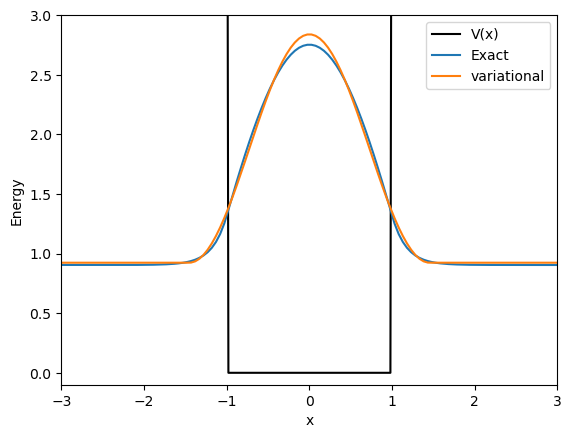

In [28]:
zoom = 2.0 # zoom factor for wavefunctions to make them more visible
plt.plot(x,V(x),'-k',label="V(x)") # plot the potential
plt.plot(x,zoom*psi_exact(x)+E_exact,label="Exact")
#plt.plot(x,zoom*np.sign(wavefunctions[n//2,0])*wavefunctions[:,0]+energies[0],label="Numerov") #plot the num-th wavefunction
plt.plot(x,zoom*psi(x,result.x)+result.fun,label="variational") # plot the variational wavefunction
plt.ylim(-0.1,3); # set limits of vertical axis for plot
plt.xlim(-3,3); # set limits of horizontal axis for plot
plt.legend();
plt.xlabel("x");
plt.ylabel("Energy");